In [40]:
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

import numpy as np

from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
import sys

import matplotlib.pyplot as plt

In [2]:
#iris = datasets.load_iris()

First we will read in the data set using Panda's read_csv() function:

In [7]:
df = pd.read_csv("data/Iris.csv")


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


*** insert jaspers part 

In [9]:
transport_df = pd.read_csv("data/transport.csv")

transport_df = transport_df.drop(columns=["date "])


Now we split the dataset into train and test sets:

In [10]:


train_df, test_df = train_test_split(transport_df, test_size=0.2)

X_train, y_train = (train_df.drop(columns=["Mode"]),
                   train_df["Mode"])

X_test, y_test = (test_df.drop(columns=["Mode"]),
                  test_df["Mode"])


Lets look at the dataset information:

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 50 to 35
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Mode          57 non-null     object
 1   Route         57 non-null     object
 2   week          57 non-null     int64 
 3   Ticket Price  57 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ KB


In [12]:
train_df.head()

,Mode,Route,week,Ticket Price
50,Plane,mumbai-chennai,3,1890
37,Plane,mumbai-Ahmedabad,2,4262
43,Train,mumbai-Ahmedabad,2,320
6,Train,mumbai-delhi,1,610
38,Plane,mumbai-Ahmedabad,3,1868


In [13]:
train_df.Route.unique()

array(['mumbai-chennai', 'mumbai-Ahmedabad', 'mumbai-delhi',
       'mumbai-Banglore', 'mumbai-hydrabad', 'mumbai-kollkatta'],
      dtype=object)

We can see that Route is a categorical variable. Therefore we need to transform this into dummy binary variables. 

number dummy variables = # categories - 1

How can we do this in python? 

We can use a column transformer! Lets apply one-hot-encoding method to encode the Route column, and scaling to the numeric columns. 

1. Specify the columns we want to apply transformations to

In [14]:
# specify numeric feats 

numeric_feats = [ 
    "week", 
    "Ticket Price",
]
# specify categorical features

cat_feat = ["Route"]

2. Use Skit-learn's columntransformer to ensure transformations happen to each column

In [15]:
ct = make_column_transformer(
    
      (
        StandardScaler(),
        numeric_feats,
      ),  
    (
        OneHotEncoder(handle_unknown="ignore"),
        cat_feat,
    ),  
    
)

Now we are ready to train our model! How do we ensure column transformation are applied without any info from the testing set leaking into the model? 

Use a pipeline! The pipeline can be used with any model. Here we are using logistic regression. After making the pipeline, you can call fit on it to build the model. We'll look at that later.

In [16]:
pipe_lr = make_pipeline(
    ct,
    LogisticRegression(max_iter = 10000)
)

Lets talk about logistic regression. Our goal here is to determine weather someone took a plane or train. We can use logistic regression for classification problems like this one. 

Logistic regression uses the training data to learn coefficients, which then can be used to calculate prediction probabilities of the each class using the sigmoid function. This allows us to calculate the predicted probability of someone taking the plane vs train based on their data. 

**Pros of logistic regression:**

    1. easy to interpret: - predicted coeffecients give us info about feature importance and direction 
    
    2. low variance model - less likely to overfit than other models such as tree based models

### Hyperparamter Optimization

hyperparamters are used to tune the model during learning. Logistic Regresion model in skit-learn has a hyperparameter called C which is used to control the fundatamental tradeoff of bias and variance, to reduce the likeliness of the model overfitting or underfitting. Larger values of C increase change of overfitting and small values of C increase chance of underfitting 

lets try optimizing the hyperparamter C:

In [17]:
train_scores = []
cv_scores = []

C = 10.0 ** np.arange(-1.5, 2, 0.5)

for c in C:
    
    pipe_lr = make_pipeline(
    ct, 
    LogisticRegression(max_iter=1000, C=c),
    )
    
    results = cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
    
    train_scores.append(results["train_score"].mean())
    cv_scores.append(results["test_score"].mean())
    

scores = pd.DataFrame({"C": C, "Train Scores": train_scores, "CV Scores": cv_scores })

scores

,C,Train Scores,CV Scores
0,0.031623,0.938357,0.898485
1,0.100000,0.991111,0.966667
2,0.316228,1.000000,0.983333
3,1.000000,1.000000,1.000000
4,3.162278,1.000000,1.000000
5,10.000000,1.000000,1.000000
6,31.622777,1.000000,1.000000


Now lets fit the model: 

In [18]:
model = make_pipeline(
    ct, 
    LogisticRegression(max_iter=1000, C=0.1),
    )

model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['week', 'Ticket Price']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Route'])])),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=1000))])

After fitting the model, we can predict on the testing set, and then print the results in a classification report. 

In [43]:
predict = model.predict(X_test)

res = classification_report(
        y_test, predict
    )

print(res)


              precision    recall  f1-score   support

       Plane       1.00      1.00      1.00         8
       Train       1.00      1.00      1.00         7

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



1.0


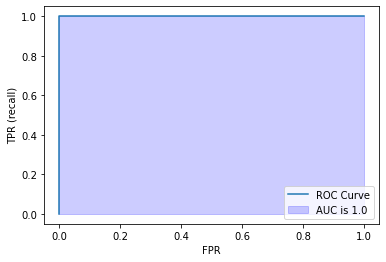

In [42]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# prediction probabilities on test set 
lr_prob = model.predict_proba(X_test)[:,1]

#y_test = y_test.map({'Train': 1, '': 0}).astype(int)

# roc_auc score on test set 
roc_lr = roc_auc_score(y_test, lr_prob)

fpr, tpr, thresholds = roc_curve(y_test, lr_prob, pos_label= "Train")

roc_lr = round(roc_lr, 4)

auc_label = "AUC is " + str(roc_lr)

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.fill_between(fpr, tpr, color='blue', alpha=0.2, label=auc_label)

plt.legend(loc="best");

print(roc_lr)

YAY! 100% accuracy!!!! This will never happen in the real world. The reason it happens here is because there is such a big price jump from train tickets to planes that the algorithm picks up on

now lets look at an example: 

In [20]:
input = X_test.iloc[[10]]
input

,Route,week,Ticket Price
13,mumbai-Banglore,2,5102


We can get the predicted probability like this:

In [21]:
print(model.classes_)
model.predict_proba(input)

['Plane' 'Train']


array([[0.85824077, 0.14175923]])

The ouput is the probability of each class. The model predicted that the probability of the input being a plane is 96%. We can also look at the hard prediction. 

In [22]:
model.predict(input)

array(['Plane'], dtype=object)

This predicts class = plane if the predicted probability for plane is over 0.5

### Decision Tree Model

In [27]:
pipe_tree = make_pipeline(
ct, 
DecisionTreeClassifier(max_depth = None) 
)

In [28]:
pipe_tree.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['week', 'Ticket Price']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Route'])])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [46]:
pred = pipe_tree.predict(X_test)

res = classification_report(
        y_test, predict
    )

print(res)


              precision    recall  f1-score   support

       Plane       1.00      1.00      1.00         8
       Train       1.00      1.00      1.00         7

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



AttributeError: 'numpy.ndarray' object has no attribute 'accuracy_score'